# Syntax-based Analysis

Given a token stream produced by a lexer, the objective of a parser is to construct a tree that captures the syntactic relation between the tokens.

## CCLearner: Deep learning clone detection 

We've already explored different code clone detection techniques, now it's time for yet another:

Li, L., Feng, H., Zhuang, W., Meng, N., & Ryder, B. (2017, September). Cclearner: A deep learning-based clone detection approach. In 2017 IEEE International Conference on Software Maintenance and Evolution (ICSME) (pp. 249-260). IEEE.

The idea of CCLearner is to compare code snippets in terms of the token frequencies. For this, the approach distinguishes the following token types:
- Reserved words
- Operators 
- Markers
- Literals
- Type identifiers
- Method idenfiers
- Qualified names
- Variable identifiers

If you think about our tokenization approach from the last chapter, you'll realize there's a problem here: While we did distinguish between different types of tokens, our tokenizer cannot distinguish between type, method, qualified, and variable identifiers -- this was all just classified as "identifier". In order to distinguish these types of tokens we need to consider the syntactic context. This is what a parser does given a token stream.

## Parsing programs

We will construct a simple parser for a trivial example language that resembles Python. Here's an example program:

```
def f(a, b)
    add(100, add(20, add(a, b)))
end

print(f(1, 2))
```

In [1]:
code = """def f(a, b)
    add(100, add(20, add(a, b)))
end

print(f(1, 2))
"""

The language contains function definitions, function calls, integer literals, and variable references. It also makes use of two undefined functions `add` and `print` which will be defined later.

### Tokenization

A prerequisite for a parser is the token stream. We implemented a lexer in the last chapter in a very basic way, and in the end realised that what we had produced was an automaton matching regular expressions. We can thus implement a simpler lexer by defining the token types in terms of regular expressions.

In [2]:
from collections import namedtuple
import re

We won't actually need the position so let's just focus on lexemes and token types.

In [3]:
Token = namedtuple('Token', 'token_type value')

For our example language, we define the following token types:

In [4]:
TOKEN_TYPES = [
    (r'\bdef\b',        'def'),
    (r'\bend\b',        'end'),
    (r'\b[a-zA-Z]+\b',  'identifier'),
    (r'\b[0-9]+\b',     'integer'),
    (r'\(',             'oparen'),
    (r'\)',             'cparen'),
    (r',',              'comma'),
]

In [5]:
def tokenize(code):
    tokens = []
    
    remaining_code = code
    
    while remaining_code:
        for regex, token_type in TOKEN_TYPES:
            match = re.match(regex, remaining_code)
            if match:
                value = match.group()
                remaining_code = remaining_code[len(value):].strip()
                tokens.append(Token(token_type, value))
    
    return tokens

In [6]:
tokenize(code)

[Token(token_type='def', value='def'),
 Token(token_type='identifier', value='f'),
 Token(token_type='oparen', value='('),
 Token(token_type='identifier', value='a'),
 Token(token_type='comma', value=','),
 Token(token_type='identifier', value='b'),
 Token(token_type='cparen', value=')'),
 Token(token_type='identifier', value='add'),
 Token(token_type='oparen', value='('),
 Token(token_type='integer', value='100'),
 Token(token_type='comma', value=','),
 Token(token_type='identifier', value='add'),
 Token(token_type='oparen', value='('),
 Token(token_type='integer', value='20'),
 Token(token_type='comma', value=','),
 Token(token_type='identifier', value='add'),
 Token(token_type='oparen', value='('),
 Token(token_type='identifier', value='a'),
 Token(token_type='comma', value=','),
 Token(token_type='identifier', value='b'),
 Token(token_type='cparen', value=')'),
 Token(token_type='cparen', value=')'),
 Token(token_type='cparen', value=')'),
 Token(token_type='end', value='end'),
 To

### Parsing

We can now build a parser that constructs a parse tree, thus implicitly defining a grammar for our language. This is slightly more involved, so we will  construct this in an object oriented way.

In [7]:
class Parser:
    def __init__(self, tokens):
        self.tokens = list(tokens)

The parser matches tokens based on a grammar. If the next token does not match a type allowed by the grammar, the parser reports an error.

In [8]:
class Parser(Parser):
    def consume(self, expected_type):
        token = self.tokens.pop(0)
        if token.token_type == expected_type:
            return token
        else:
            raise RuntimeError(
                f"Expected token type {expected_type!r} "
                f"but got {token.token_type!r}."
            )

We now implicitly define our grammar by implementing each production as a function. Integer literals simply produce leaf nodes.

In [9]:
class Parser(Parser):
    def parse_integer(self):
        return dict(
            node_type='int',
            value=int(self.consume('integer').value),
        )

In [10]:
example = "5"
parser = Parser(tokenize(example))
parser.parse_integer()

{'node_type': 'int', 'value': 5}

Similarly, variable nodes are leaf nodes containing the variable name.

In [11]:
class Parser(Parser):
    def parse_var_ref(self):
        return dict(
            node_type='var',
            name=self.consume('identifier').value,
        )

In [12]:
example = "x"
parser = Parser(tokenize(example))
parser.parse_var_ref()

{'node_type': 'var', 'name': 'x'}

Function calls are slightly more involved since they are not just individual tokens. To determine which grammar rule we are matching we sometimes need to look ahead.

In [13]:
class Parser(Parser):
    def peek(self, expected_type, offset=0):
        return self.tokens[offset].token_type == expected_type

A function call consists of a call node that contains the name of the function called, and nodes for the arguments, if there are any.

In [14]:
class Parser(Parser):
    def parse_call(self):
        name = self.consume('identifier').value
        arg_exprs = list(self.parse_arg_exprs())
        return dict(
            node_type='call',
            name=name,
            arg_exprs=arg_exprs,\
        )

    def parse_arg_exprs(self):
        self.consume('oparen')
        if not self.peek('cparen'):
            yield self.parse_expr()
            while self.peek('comma'):
                self.consume('comma')
                yield self.parse_expr()
        self.consume('cparen')

In [15]:
class Parser(Parser):
    def parse_expr(self):
        if self.peek('integer'):
            return self.parse_integer()
        elif self.peek('identifier') and self.peek('oparen', 1):
            return self.parse_call()
        else:
            return self.parse_var_ref()

In [16]:
example = "foo(5)"
parser = Parser(tokenize(example))
parser.parse_call()

{'node_type': 'call',
 'name': 'foo',
 'arg_exprs': [{'node_type': 'int', 'value': 5}]}

In [17]:
class Parser(Parser):
    def parse_def(self):
        self.consume('def')
        name = self.consume('identifier').value
        arg_names = list(self.parse_arg_names())
        body = self.parse_expr()
        self.consume('end')
        return dict(
            node_type='def',
            name=name,
            arg_names=arg_names,
            body=body,
        )

    def parse_arg_names(self):
        self.consume('oparen')
        if self.peek('identifier'):
            yield self.consume('identifier').value
            while self.peek('comma'):
                self.consume('comma')
                yield self.consume('identifier').value
        self.consume('cparen')

In [18]:
parser = Parser(tokenize(code))
parser.parse_def()

{'node_type': 'def',
 'name': 'f',
 'arg_names': ['a', 'b'],
 'body': {'node_type': 'call',
  'name': 'add',
  'arg_exprs': [{'node_type': 'int', 'value': 100},
   {'node_type': 'call',
    'name': 'add',
    'arg_exprs': [{'node_type': 'int', 'value': 20},
     {'node_type': 'call',
      'name': 'add',
      'arg_exprs': [{'node_type': 'var', 'name': 'a'},
       {'node_type': 'var', 'name': 'b'}]}]}]}}

Finally, we need to implement the start rule of our grammar.

In [19]:
class Parser(Parser):
    def parse(self):
        while self.tokens:
            if self.peek('def'):
                yield self.parse_def()
            else:
                yield self.parse_call()

In [20]:
tree = Parser(tokenize(code)).parse()

In [21]:
list(tree)

[{'node_type': 'def',
  'name': 'f',
  'arg_names': ['a', 'b'],
  'body': {'node_type': 'call',
   'name': 'add',
   'arg_exprs': [{'node_type': 'int', 'value': 100},
    {'node_type': 'call',
     'name': 'add',
     'arg_exprs': [{'node_type': 'int', 'value': 20},
      {'node_type': 'call',
       'name': 'add',
       'arg_exprs': [{'node_type': 'var', 'name': 'a'},
        {'node_type': 'var', 'name': 'b'}]}]}]}},
 {'node_type': 'call',
  'name': 'print',
  'arg_exprs': [{'node_type': 'call',
    'name': 'f',
    'arg_exprs': [{'node_type': 'int', 'value': 1},
     {'node_type': 'int', 'value': 2}]}]}]

We can visualize the syntax tree using a little helper function.

In [22]:
from graphviz import Digraph

unique_id = 0

def print_tree(node):
    dot = Digraph()
    num = 0
    dot.node("root", "start")
    for child in list(node):
        child_id = add_nodes(dot, child, f"root-{num}")
        dot.edge("root", child_id)
        num += 1
    return dot

def add_nodes(dot, node, name):
    global unique_id
   
    if isinstance(node, dict):
        dot.node(str(id(node)), name)
        for key, value in node.items():
            child_id = add_nodes(dot, value, key)
            dot.edge(str(id(node)), child_id)
        return str(id(node))
                
    elif isinstance(node, str):
            node_id = unique_id
            unique_id += 1
            dot.node(str(node_id), node)
            return str(node_id)

    elif isinstance(node, int):
            node_id = unique_id
            unique_id += 1
            dot.node(str(node_id), str(node))
            return str(node_id)

    elif isinstance(node, list):
        dot.node(str(id(node)), name)
        num = 0
        for child in node:
            child_id = add_nodes(dot, child, f"{name}-{num}")
            dot.edge(str(id(node)), child_id)
            num += 1
        return str(id(node))

In [23]:
root_nodes = list(Parser(tokenize(code)).parse())

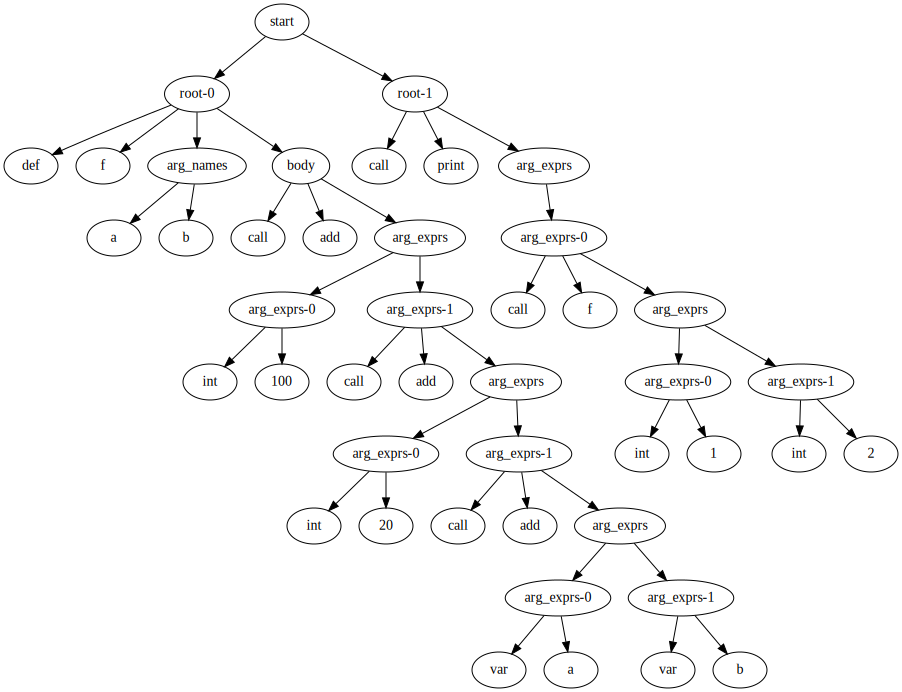

In [24]:
print_tree(root_nodes)

Note that this is not yet an _abstract_ syntax tree: It is a parse tree, exactly representing the grammar used, including all tokens. In contrast, an abstract syntax tree describes the parse tree logically and does not need to contain all the syntactical constructs. While a parse tree only has non-terminal nodes as non-leaf nodes, an abstract syntax tree can, for example, contain operators as interor nodes, with the operands being leaves.

### Revisiting CCLearner

If we want to parse real languages, we'll often find existing parsers. To process Java code in Python, we can use Javalang.

In [25]:
code1 = """
public class Foo {
  public void foo(int x) {
    System.out.println("Hello Clone!");
    int j = 10;
    for(int i = 0; i < x; i++) {
      System.out.println("Another iteration");
    }
  }
}
"""

In [26]:
code2 = """
public class Foo {
  private int y = 0;
  
  public void foo(int x) {
    System.out.println("Hello Clone!");
    int j = 10 + y;
    for(int i = 0; i < x; i++) {
      System.out.println("Another iteration");
    }
  }
}
"""

In [27]:
import javalang

In [28]:
javalang.parse.parse(code2)

CompilationUnit(imports=[], package=None, types=[ClassDeclaration(annotations=[], body=[FieldDeclaration(annotations=[], declarators=[VariableDeclarator(dimensions=[], initializer=Literal(postfix_operators=[], prefix_operators=[], qualifier=None, selectors=[], value=0), name=y)], documentation=None, modifiers={'private'}, type=BasicType(dimensions=[], name=int)), MethodDeclaration(annotations=[], body=[StatementExpression(expression=MethodInvocation(arguments=[Literal(postfix_operators=[], prefix_operators=[], qualifier=None, selectors=[], value="Hello Clone!")], member=println, postfix_operators=[], prefix_operators=[], qualifier=System.out, selectors=[], type_arguments=None), label=None), LocalVariableDeclaration(annotations=[], declarators=[VariableDeclarator(dimensions=[], initializer=BinaryOperation(operandl=Literal(postfix_operators=[], prefix_operators=[], qualifier=None, selectors=[], value=10), operandr=MemberReference(member=y, postfix_operators=[], prefix_operators=[], quali

It might be helpful to see the tree structure visualised.

In [29]:
from graphviz import Digraph
def print_tree(tree):
    unique_id = 1
    dot = Digraph()
    for path, node in tree:
        dot.node(str(id(node)), str(type(node)))
        
        for child in node.children:
            if isinstance(child, javalang.ast.Node):
                dot.edge(str(id(node)), str(id(child)))
            elif type(child) == str:
                strid = str(unique_id)
                unique_id = unique_id + 1
                dot.node(strid, child)
                dot.edge(str(id(node)), strid)
            elif type(child) == list:
                for lc in child:
                    dot.edge(str(id(node)), str(id(lc)))
                 
    return dot

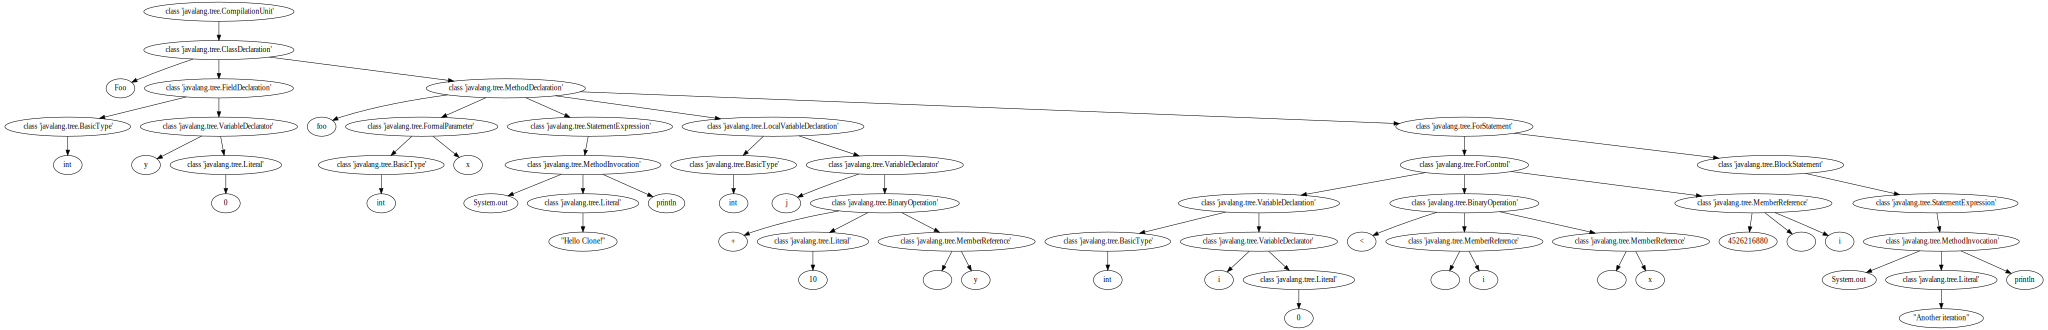

In [30]:
tree = javalang.parse.parse(code2)
print_tree(tree)

In contrast to our parse tree shown earlier, this is an actual _abstract_ syntax tree. To construct an AST, one needs to extend the implementations of the different productions to instantiate the appropriate node structures required.

CCLearner defines eight different types of tokens for the clone analysis.

In [31]:
reserved   = {} # C1
operators  = {} # C2
markers    = {} # C3
literals   = {} # C4
type_ids   = {} # C5
method_ids = {} # C6
qualified_ids = {} # C7
variable_ids  = {} # C8

In [32]:
def increment(dictionary, key):
    if key in dictionary:
        dictionary[key] += 1
    else:
        dictionary[key] = 1

The first three types of tokens can easily be extracted using a tokenizer.

In [33]:
for token in javalang.tokenizer.tokenize(code2):
    # C1
    if token.__class__.__name__ == "Keyword":
        increment(reserved, token.value)

    # C2
    elif token.__class__.__name__ == "Operator":
        increment(operators, token.value)
    
    # C3
    elif token.__class__.__name__ == "Separator":
        increment(markers, token.value)

Type C4 (Literals) already comes with some challenges. For example, consider the following snippet of code and its tokens:

In [34]:
list(javalang.tokenizer.tokenize("int i = -1;"))

[BasicType "int" line 1, position 1,
 Identifier "i" line 1, position 5,
 Operator "=" line 1, position 7,
 Operator "-" line 1, position 9,
 DecimalInteger "1" line 1, position 10,
 Separator ";" line 1, position 11]

The number `-1` is split into two tokens, but for the sake of CCLearner's analysis it would be preferable to use a single number.

To extract literals values, we can, however, use the AST:

In [35]:
example_tree = javalang.parse.parse("class Test {int i = -1;}")

In [36]:
for _, node in example_tree.filter(javalang.tree.Literal):
    print(f"Literal: {node}")

Literal: Literal(postfix_operators=[], prefix_operators=['-'], qualifier=None, selectors=[], value=1)


We thus need to prepend the prefix operators when collecting literals.

In [37]:
for _, node in tree.filter(javalang.tree.Literal):
    result = "".join(node.prefix_operators) + node.value
    # C4
    increment(literals, result)

In [38]:
for _, node in tree.filter(javalang.tree.Type):
    # C5
    increment(type_ids, node.name)

For C6 we require all method names, which are part of MethodDeclarations and MethodInvocations

In [39]:
for _, node in tree.filter(javalang.tree.MethodInvocation):
    # C6
    increment(method_ids, node.member)

In [40]:
for _, node in tree.filter(javalang.tree.MethodDeclaration):
    # C6
    increment(method_ids, node.name)

Qualified names (C7 tokens) are explicitly available in the AST.

In [41]:
for _, node in tree.filter(javalang.tree.Primary):
    # C7
    if node.qualifier:
        increment(qualified_ids, node.qualifier)

Variable identifiers (C8 tokens) are slightly more inconvenient to extract than the other tokens because they can occur at multiple different types of locations.

In [42]:
for _, node in tree.filter(javalang.tree.VariableDeclarator):
    # C8
    increment(variable_ids, node.name)

for _, node in tree.filter(javalang.tree.FormalParameter):
    # C8
    increment(variable_ids, node.name)
    
for _, node in tree.filter(javalang.tree.MemberReference):
    # C8
    increment(variable_ids, node.member)

In [43]:
print(reserved)
print(operators)
print(markers)
print(literals)
print(type_ids)
print(method_ids)
print(qualified_ids)
print(variable_ids)

{'class': 1, 'void': 1, 'for': 1}
{'=': 3, '+': 1, '<': 1, '++': 1}
{'{': 3, ';': 6, '(': 4, ')': 4, '.': 4, '}': 3}
{'0': 2, '"Hello Clone!"': 1, '10': 1, '"Another iteration"': 1}
{'int': 4}
{'println': 2, 'foo': 1}
{'System.out': 2}
{'y': 2, 'j': 1, 'i': 3, 'x': 2}


Now we can place all the conditions from above into a function that derives the tokens for a given snippet of code.

In [44]:
def get_tokens(code):
    
    tokens = { 
        "reserved" : {},
        "operators" : {},
        "markers" : {},
        "literals" : {},
        "type_ids" : {},
        "method_ids" : {},
        "qualified_ids" : {},
        "variable_ids" : {}
             }

    for token in javalang.tokenizer.tokenize(code):
        # C1
        if token.__class__.__name__ == "Keyword":
            increment(tokens["reserved"], token.value)
        # C2
        elif token.__class__.__name__ == "Operator":
            increment(tokens["operators"], token.value)    
        # C3
        elif token.__class__.__name__ == "Separator":
            increment(tokens["markers"], token.value)

    tree = javalang.parse.parse(code)
    for _, node in tree.filter(javalang.tree.Literal):
        result = "".join(node.prefix_operators) + node.value
        # C4
        increment(tokens["literals"], result)
    for _, node in tree.filter(javalang.tree.Type):
        # C5
        increment(tokens["type_ids"], result)
    for _, node in tree.filter(javalang.tree.MethodInvocation):
        # C6
        increment(tokens["method_ids"], node.member)
    for _, node in tree.filter(javalang.tree.MethodDeclaration):
        # C6
        increment(tokens["method_ids"], node.name)
    for _, node in tree.filter(javalang.tree.Primary):
        # C7
        if node.qualifier:
            increment(tokens["qualified_ids"], node.qualifier)
    for _, node in tree.filter(javalang.tree.VariableDeclarator):
        # C8
        increment(tokens["variable_ids"], node.name)
    for _, node in tree.filter(javalang.tree.FormalParameter):
        # C8
        increment(tokens["variable_ids"], node.name)
    for _, node in tree.filter(javalang.tree.MemberReference):
        increment(tokens["variable_ids"], node.member)
        # C8
        
    return tokens

In [45]:
get_tokens(code1)

{'reserved': {'class': 1, 'void': 1, 'for': 1},
 'operators': {'=': 2, '<': 1, '++': 1},
 'markers': {'{': 3, '(': 4, ')': 4, '.': 4, ';': 5, '}': 3},
 'literals': {'"Hello Clone!"': 1, '10': 1, '0': 1, '"Another iteration"': 1},
 'type_ids': {'"Another iteration"': 3},
 'method_ids': {'println': 2, 'foo': 1},
 'qualified_ids': {'System.out': 2},
 'variable_ids': {'j': 1, 'i': 3, 'x': 2}}

The similarity for a given cataegory tokens is calculated as 1 minus the difference of token frequencies over the sums of token frequencies.

In [46]:
def sim_score(tokens1, tokens2):
    if not tokens1 or not tokens2:
        return 0.5 # See paper
    
    tokens = list(tokens1.keys()) + list(tokens2.keys())
    
    diff = 0
    summ = 0 
    
    for token in tokens:
        num1 = tokens1[token] if token in tokens1 else 0
        num2 = tokens2[token] if token in tokens2 else 0
        diff += num1 - num2
        summ += num1 + num2
    
    return 1.0 - diff / summ

In [47]:
code3 = """
public class Bar {
  public void bar(int x) {
    System.out.println("Completely different text!");
    int j = 200; // completely different numbers
    for(int i = 100; i < x; i++) {
      System.out.println("More complete different text");
    }
  }
}
"""

In [48]:
code4 = """
public class Bar {
  public void bar(int x) {
        MultiLayerNetwork model = new MultiLayerNetwork(conf);
        model.init();
        model.setListeners(Collections.singletonList((IterationListener) new ScoreIterationListener(10)));


        for (int n = 0; n < nEpochs; n++) {
            model.fit(trainIter);
        }

        File model_File = new File(output_dir + "model.mdl");
  }
}
"""

In [49]:
tokens1 = get_tokens(code1)
tokens2 = get_tokens(code2)
tokens3 = get_tokens(code3)
tokens4 = get_tokens(code4)

In [50]:
sim_score(tokens1["markers"], tokens2["markers"])

1.0212765957446808

In [51]:
def feature_vector(tokens1, tokens2):
    similarity = []
    for key in tokens1.keys():
        similarity.append(sim_score(tokens1[key], tokens2[key]))
    return similarity

In [52]:
feature_vector(tokens1, tokens2)

[1.0,
 1.1578947368421053,
 1.0212765957446808,
 1.1111111111111112,
 1.1428571428571428,
 1.0,
 1.0,
 1.0769230769230769]

In [53]:
feature_vector(tokens1, tokens4)

[1.2,
 1.1578947368421053,
 1.2333333333333334,
 0.9090909090909091,
 1.4545454545454546,
 1.25,
 1.3333333333333333,
 1.1578947368421053]

At this point, we can train a machine learning model given a labelled dataset of pairs of code snippets. For each pair of code snippets we would calculate the feature vector, and then update train the model based on the label for that pair. However, rather than doing this, we will take our prediction even a step further and use more syntactical information for our prediction.

## Code Embeddings

Before moving on to somewhat more classical examples of syntax-based analysis of code, we consider a recent trend: In order to allow machine learning models to make predictions on code, we need to convert the source code to a format that is suitable as input for ML models, i.e., numerical vectors, typically referred to as _embeddings_. 

A well-known example of embeddings in a different domain is Word2vec: Word2vec is a two-layer neural net that processes text by “vectorizing” words. Its input is a text corpus and its output is a set of vectors: feature vectors that represent words in that corpus. 

The purpose and usefulness of Word2vec is to group the vectors of similar words together in vectorspace. That is, it detects similarities mathematically. Word2vec creates vectors that are distributed numerical representations of word features, features such as the context of individual words.

Given enough data, usage and contexts, Word2vec can make highly accurate guesses about a word’s meaning based on past appearances. Those guesses can be used to establish a word’s association with other words (e.g. “man” is to “boy” what “woman” is to “girl”), or cluster documents and classify them by topic. Those clusters can form the basis of search, sentiment analysis and recommendations in such diverse fields as scientific research, legal discovery, e-commerce and customer relationship management.

The output of the Word2vec neural net is a vocabulary in which each item has a vector attached to it, which can be fed into a deep-learning net or simply queried to detect relationships between words.

In [54]:
import gensim.downloader
glove_vectors = gensim.downloader.load('glove-twitter-25')

In [55]:
glove_vectors.most_similar('twitter')

[('facebook', 0.948005199432373),
 ('tweet', 0.9403423070907593),
 ('fb', 0.9342358708381653),
 ('instagram', 0.9104824066162109),
 ('chat', 0.8964964747428894),
 ('hashtag', 0.8885937333106995),
 ('tweets', 0.8878158330917358),
 ('tl', 0.8778461217880249),
 ('link', 0.8778210878372192),
 ('internet', 0.8753897547721863)]

# ASTNN

Recent work provides the strong evidence that syntactic knowledge contributes more in modeling source code
and can obtain better representation than traditional token-based methods. We will consider one example approach to creating code embeddings from syntactic information, ASTNN:

Zhang, J., Wang, X., Zhang, H., Sun, H., Wang, K., & Liu, X. (2019, May). A novel neural source code representation based on abstract syntax tree. In 2019 IEEE/ACM 41st International Conference on Software Engineering (ICSE) (pp. 783-794). IEEE.

ASTNN splits the large AST of one code fragment into a set of small trees at the statement level and performs tree-based neural embeddings on all statement trees. Recurrent Neural Networks (RNNs) are used to encode statements and the sequential dependency between the statements into a vector. These vectors capture the naturalness of source code, and can serve as a neural source code representation.


As an example application for these embeddings, we can once again use code clone detection, which boils down to the following:

- Compute vector embeddings $e_1$, $e_2 \in \mathbb{R}^m$ for two code snippets
- The distance between the code snippets is $r = |e_1 - e_2| \in \mathbb{R}^m$
- This can be reduced to a clone probability using a linear layer with sigmoid activation function $p = \textrm{sigmoid}(r) \in [0,1]$

## Preprocessing

The first step in producing the code embeddings consists of parsing the code, transforming the AST into a sequence of statement trees, and then replacing string labels of the tree nodes with numeric indices.

We will eventually apply our encoding to a dataset of C programs (using the model trained by the authors of ASTNN), so in the following we will consider the syntax trees of C programs created by Python's C Parser library: [PyCParser](https://github.com/eliben/pycparser)

In [56]:
code = """
int foo() {}

int main(int argc, char** argv) {
  if (argc > 0) {
      foo();
  }
  return 0;
}
"""

In [57]:
import pycparser
code_parser = pycparser.c_parser.CParser()

ast = code_parser.parse(code)
ast

FileAST(ext=[FuncDef(decl=Decl(name='foo',
                               quals=[
                                     ],
                               align=[
                                     ],
                               storage=[
                                       ],
                               funcspec=[
                                        ],
                               type=FuncDecl(args=None,
                                             type=TypeDecl(declname='foo',
                                                           quals=[
                                                                 ],
                                                           align=None,
                                                           type=IdentifierType(names=['int'
                                                                                     ]
                                                                               )
                                  

At the core of the ASTNN lies the extraction of statement trees from the AST. A statement tree is essentially a substree of the AST for a statement-node, and the list of statement trees is achieved by a preorder traversal of the AST.

In [58]:
def get_statements(node):
    name = node.__class__.__name__
    print(f"Current node: {name}")
    for _, child in node.children():
        get_statements(child)
    
get_statements(ast)

Current node: FileAST
Current node: FuncDef
Current node: Decl
Current node: FuncDecl
Current node: TypeDecl
Current node: IdentifierType
Current node: Compound
Current node: FuncDef
Current node: Decl
Current node: FuncDecl
Current node: ParamList
Current node: Decl
Current node: TypeDecl
Current node: IdentifierType
Current node: Decl
Current node: PtrDecl
Current node: PtrDecl
Current node: TypeDecl
Current node: IdentifierType
Current node: TypeDecl
Current node: IdentifierType
Current node: Compound
Current node: If
Current node: BinaryOp
Current node: ID
Current node: Constant
Current node: Compound
Current node: FuncCall
Current node: ID
Current node: Return
Current node: Constant


For our example program, we would like to create statement trees for the if statement (`If`), the function call (`FuncCall`) , and the return statement (`Return`). ASTNN also treats function declarations (`FuncDef`) as special statement nodes.

In [59]:
def get_statements(node):
    name = node.__class__.__name__
    if name in ["FuncDef", "FuncCall", "If", "Return"]:
        print(f"Statement node: {name}")
    for _, child in node.children():
        get_statements(child)
    
get_statements(ast)

Statement node: FuncDef
Statement node: FuncDef
Statement node: If
Statement node: FuncCall
Statement node: Return


A statement tree (ST-tree) rooted by the statement node $s \in S$ is the tree consisting of node s and all of
its descendants, but excluding any statements nodes. For example, for a method call statement, all child nodes are in the statement tree, since none of the children are statements. On the other hand, an if-statement consists of an expression as well as the conditionally executed statements:

In [60]:
code_parser.parse("int main() {if (42 > 0) { foo(); } }")

FileAST(ext=[FuncDef(decl=Decl(name='main',
                               quals=[
                                     ],
                               align=[
                                     ],
                               storage=[
                                       ],
                               funcspec=[
                                        ],
                               type=FuncDecl(args=None,
                                             type=TypeDecl(declname='main',
                                                           quals=[
                                                                 ],
                                                           align=None,
                                                           type=IdentifierType(names=['int'
                                                                                     ]
                                                                               )
                                

Consequently, when creating statement trees, if we encounter a `FuncDef`, `If`, `While`, `DoWhile`, or `Switch` statement, then we only include the first child in the statement tree, and ignore all other children (which are statements).

A second exception are for-loops, which contain of multiple children: The `init`, `cond`, and `next` children are part of the for-statement itself, while the last child (`stmt`) is a statement and should be excluded.

In [61]:
code_parser.parse("int main() {for (int i = 0; i < 10; i++) { foo(); } }")

FileAST(ext=[FuncDef(decl=Decl(name='main',
                               quals=[
                                     ],
                               align=[
                                     ],
                               storage=[
                                       ],
                               funcspec=[
                                        ],
                               type=FuncDecl(args=None,
                                             type=TypeDecl(declname='main',
                                                           quals=[
                                                                 ],
                                                           align=None,
                                                           type=IdentifierType(names=['int'
                                                                                     ]
                                                                               )
                                

Note that the for-loop (and the other block-constructs we considered previously) define a single statement as child node, but of course it is common that they can contain more complex code blocks. In pycparser, these are are captured by `Compound` nodes.

It is also worth noting that pycparser stores nodes as tuples `(str, node)`, so when traversing the AST to create statement trees we need to look at the second entry of such a tuple only. 

In [62]:
class ASTNode(object):
    def __init__(self, node):
        self.node = node
        self.name = self.node.__class__.__name__
        children = node.children()
        if self.name in ['FuncDef', 'If', 'While', 'DoWhile', 'Switch']:
            self.__children = [ASTNode(children[0][1])]
        elif self.name == 'For':
            children = node.children()
            self.__children = [ASTNode(children[c][1]) for c in range(0, len(children) - 1)]
        else:
            self.__children = [ASTNode(child) for _, child in node.children()]

    def children(self):
        return self.__children
    
    def __repr__(self):
        return f"{self.name}: {self.children()}"

Now that we have a class to capture statement trees, we just need to implement the tree traversal to collect them for the statements we are interested (for the sake of the example for now only `FuncDef`, `FuncCall`, `If`, `Return`).

In [63]:
def get_statement_trees(node):
    name = node.__class__.__name__
    trees = []
    if name in ["FuncDef", "FuncCall", "If", "Return"]:
        trees.append(ASTNode(node))

    for _, child in node.children():
        trees.extend(get_statement_trees(child))
    
    return trees
    
get_statement_trees(ast)

[FuncDef: [Decl: [FuncDecl: [TypeDecl: [IdentifierType: []]]]],
 FuncDef: [Decl: [FuncDecl: [ParamList: [Decl: [TypeDecl: [IdentifierType: []]], Decl: [PtrDecl: [PtrDecl: [TypeDecl: [IdentifierType: []]]]]], TypeDecl: [IdentifierType: []]]]],
 If: [BinaryOp: [ID: [], Constant: []]],
 FuncCall: [ID: []],
 Return: [Constant: []]]

Our statement trees currently only describe the syntactic structure, but we have lost the lexical information about the actual tokens used (e.g., which methods were called). We add a `token` to our `ASTNode` class.
- If the node is a leaf node (i.e., a variable name or a literal), then we use the actual lexeme.
- For type declaration nodes we use the name of the type.
- For operators, we use the operator symbol.
- In other cases, we use the token type as the name.

In [64]:
class ASTNode(ASTNode):
    def __init__(self, node):
        super().__init__(node)
        self.token = self.get_token()
    
    def __repr__(self):
        return f"{self.token}: {self.children()}"
    
    def is_leaf(self):
        return len(self.node.children()) == 0    
    
    def get_token(self, lower=True):
        name = self.node.__class__.__name__
        token = name

        if self.is_leaf():
            attr_names = self.node.attr_names
            if 'names' in attr_names:
                token = self.node.names[0] # Identifiers
            elif 'name' in attr_names:
                token = self.node.name # ID
            else:
                token = self.node.value # Constant
        else:
            if name == 'TypeDecl':
                token = self.node.declname
            if self.node.attr_names:
                attr_names = self.node.attr_names
                if 'op' in attr_names:
                    token = self.node.op # Binary Op

        return token

In [65]:
get_statement_trees(ast)

[FuncDef: [Decl: [FuncDecl: [foo: [int: []]]]],
 FuncDef: [Decl: [FuncDecl: [ParamList: [Decl: [argc: [int: []]], Decl: [PtrDecl: [PtrDecl: [argv: [char: []]]]]], main: [int: []]]]],
 If: [>: [argc: [], 0: []]],
 FuncCall: [foo: []],
 Return: [0: []]]

Since a neural network cannot process string labels of the trees, we first need to convert these to integers by taking their index in a vocabulary. In ASTNN this is done using a pre-trained word2vec vocabulary. If the label cannot be found, then an out-of-vocabulary index is assigned.

The word2vec model is trained on the source code corpus; we will simply use the model generated by the ASTNN authors here.

In [66]:
from gensim.models import Word2Vec
w2v = Word2Vec.load("data/astnn/w2v_128")

The index of a word can be determined by directly looking the word up in the model.

In [67]:
def label_to_index(label: str) -> int:
    return w2v.wv.get_index(label, default=len(w2v.wv))

To convert the labels of a statement tree to numbers, we apply this to each node.

In [68]:
def tree_to_index(node: ASTNode):
    token = node.token
    indices = [label_to_index(token)]
    for child in node.children():
        indices.append(tree_to_index(child))
    return indices

Let's have a look at the statement trees for our example snippet.

In [69]:
from typing import Any
import pycparser

for s in get_statement_trees(ast):
    print(tree_to_index(s))

[33, [2, [30, [9161, [4]]]]]
[33, [2, [30, [74, [2, [217, [4]]], [2, [68, [68, [218, [43]]]]]], [40, [4]]]]]
[15, [48, [217], [5]]]
[11, [9161]]
[39, [5]]


Our implementation of the AST traversal is limited to our example code snippet, and will not work on more general code snippets. To apply this to any C code snippets, let's use the full version, which mainly differs in which aspects of the AST it takes into consideration. 

In [70]:
ast_block_token = ['FuncDef', 'If', 'While', 'DoWhile', 'Switch']


class ASTNode(object):
    def __init__(self, node, single=False):
        self.node = node

        self.__is_str = isinstance(self.node, str)
        self.token = self.get_token()

        if single:
            self.__children = []
        else:
            self.__children = self.add_children()

    def is_leaf(self):
        if self.__is_str:
            return True

        return len(self.node.children()) == 0

    def add_children(self):
        if self.__is_str:
            return []
        children = self.node.children()
        if self.token in ast_block_token:
            return [ASTNode(children[0][1])]
        elif self.token == 'For':
            return [ASTNode(children[c][1]) for c in range(0, len(children) - 1)]
        else:
            return [ASTNode(child) for _, child in children]

    def children(self):
        return self.__children

The retrieval of the right token is also slightly more involved beyond our snippet.

In [71]:
class ASTNode(ASTNode):
    def get_token(self, lower=True):
        if self.__is_str:
            return self.node

        name = self.node.__class__.__name__
        token = name
        is_name = False

        if self.is_leaf():
            attr_names = self.node.attr_names
            if attr_names:
                if 'names' in attr_names:
                    token = self.node.names[0]
                elif 'name' in attr_names:
                    token = self.node.name
                    is_name = True
                else:
                    token = self.node.value
            else:
                token = name
        else:
            if name == 'TypeDecl':
                token = self.node.declname
            if self.node.attr_names:
                attr_names = self.node.attr_names
                if 'op' in attr_names:
                    if self.node.op[0] == 'p':
                        token = self.node.op[1:]
                    else:
                        token = self.node.op
        if token is None:
            token = name
        if lower and is_name:
            token = token.lower()
        return token
    
    def __repr__(self):
        return f"{self.get_token()}: {self.children()}"

Finally, our retrieval of statement trees was slightly simplified. For example, the original ASTNN implementation also creates nodes for compound statements, and adds dedicated `End` nodes. These end-nodes do not match lexical tokens but inform the inference algorithm about the indentation of the code.

In [72]:
def get_statements(node, statement_sequence):
    children = node.children()
    name = node.__class__.__name__
    if name in ['FuncDef', 'If', 'For', 'While', 'DoWhile']:
        statement_sequence.append(ASTNode(node))
        if name != 'For':
            inner_offset = 1
        else:
            inner_offset = len(children) - 1
        for i in range(inner_offset, len(children)):
            child = children[i][1]
            if child.__class__.__name__ not in ['FuncDef', 'If', 'For', 'While', 'DoWhile', 'Compound']:
                statement_sequence.append(ASTNode(child))
            get_statements(child, statement_sequence)
    elif name == 'Compound':
        statement_sequence.append(ASTNode(name))
        for _, child in children:
            if child.__class__.__name__ not in ['If', 'For', 'While', 'DoWhile']:
                statement_sequence.append(ASTNode(child))
            get_statements(child, statement_sequence)
        statement_sequence.append(ASTNode('End'))
    else:
        for _, child in children:
            get_statements(child, statement_sequence)

In [73]:
statements = []
get_statements(ast, statements)
statements

[FuncDef: [Decl: [FuncDecl: [foo: [int: []]]]],
 Compound: [],
 End: [],
 FuncDef: [Decl: [FuncDecl: [ParamList: [Decl: [argc: [int: []]], Decl: [PtrDecl: [PtrDecl: [argv: [char: []]]]]], main: [int: []]]]],
 Compound: [],
 If: [>: [argc: [], 0: []]],
 Compound: [],
 FuncCall: [foo: []],
 End: [],
 Return: [0: []],
 End: []]

In [74]:
def to_statement_trees(ast) -> list[Any]:
    statements = []
    get_statements(ast, statements)
    tree = []
    for s in statements:
        tree.append(tree_to_index(s))
    return tree

## Model

Given the numeric encoding of tokens in the statement trees, the next step of building the embeddings consists of recursively creating vectors for statement trees.

The lexical vector $v_n$ for a node $n$ is calculated as $v_n = W_e^T x_n$, where $x_n$ is the numerical representation of node $n$ (i.e., the index retrieved from Word2vec).

The vector representation of a node $n$ is computed by the following equation:

$h = \sigma (W_n^T + \displaystyle\sum_{i \in [1, C]} h_i + b_n)$


Here, $W_n \in \mathcal{R}^{d \times k}$ is the weight matrix with encoding dimensions $k$.  $b_n$ is a bias term, $h_i$ is the hidden state for each child $i$, $h$ is the updated hidden state, and $\sigma$ is the activation function, which in ASTNN is the identity function.

The final encoding is then sampled with max pooling: $e_t = [max(h_{i1}, \ldots, max(h_{ik})], i = 1, \ldots, N$

### Dynamic Batching of trees (Algorithm 1, function `DynamicBatch()`)

The computation of the vector encoding of a statement tree recursively depends on the vector encoding of its subnodes in the tree. Furthermore, For example, directly calculating $h$ for the two parents in one batch may also be impossible if the number of children of the two parents differs. This means that the computation of $h$ cannot be parallelised, but unfortunately that is exactly what is necessary in order to train a model on a large dataset.

The authors of ASTNN have developed a batch processing algorithm that allows to encode multiple samples (i.e., code fragments) simultaneously. However, generally batch processing on multiway ST-trees makes it difficult since the number of children nodes varies for the parent nodes in the same position of one batch.

The algorithm batches $L$ samples of statement trees and then breadthfirst traverses them starting from the root nodes. For the current nodes $ns$ in the same position of the batch, the algorithm first calculates $v_n$ in batch, and then group all their children nodes by the node positions. That is, it groups all nodes at the same depth in the statement trees at the same position, such that the calculation of these nodes can be performed in parallel. Based on the grouping, the algorithm recursively performs batch processing on all children nodes. After getting the results of all children nodes, $h$ can be computed in batch, and all node vectors of calculated statement trees are recorded.

![Children Batching](figures/5_astnn_children_batching.png)

Children batching

- $ns$: `nodes`
- $C$: `children`
- $CI$: `children_index`

Since our focus lies in the program analysis itself more than on the construction of an effective machine learning pipeline, we will present the ML-related code here, but will not go into as much detail as for the previous parts.

The following code sets up the batch tree encoder used by ASTNN, and initially sets up the required datastructures.

In [75]:
import numpy.typing
import tensorflow as tf
from tensorflow import keras
from typing import Optional, Union


class BatchTreeEncoder(tf.Module):
    def __init__(
        self,
        vocab_size: int,
        vocab_embedding_dim: int,
        encode_dim: int,
        batch_size: int = 64,
        pretrained_weight: Optional[numpy.typing.ArrayLike] = None,
    ):
        super().__init__()
        self.embedding = keras.layers.Embedding(vocab_size, vocab_embedding_dim)
        self.embedding_dim = vocab_embedding_dim
        self.encode_dim = encode_dim
        self.W_c = keras.layers.Dense(encode_dim, input_shape=(vocab_embedding_dim,))
        self.activation = tf.keras.activations.relu
        self.batch_size = batch_size
        self.node_list: list[tf.Tensor] = []
        self.batch_node: Union[list[int], tf.Tensor] = []

        # pretrained embedding from word2vec
        if pretrained_weight is not None:
            self.embedding.build((vocab_size, vocab_embedding_dim))
            self.embedding.set_weights([pretrained_weight])

The actual traversal implements Algorithm 1 from the ASTNN paper. 

In [76]:
class BatchTreeEncoder(BatchTreeEncoder):
    def traverse(self, nodes, batch_index: list[int]) -> Optional[tf.Tensor]:
        # Recursively compute embedding of multiple statement trees `nodes`
        size = len(nodes)
        if not size:
            return None

        # line 9: create an output placeholder `BC` for the batch input
        batch_current = tf.zeros([size, self.embedding_dim], tf.float32)

        index: list[int] = []
        current_node: list[int] = []
        children: list[list[int]] = []
        children_index: list[list[int]] = []

        for i, n in enumerate(nodes):
            index.append(i)
            current_node.append(n[0])

            for j, child in enumerate(n[1:]):
                # check if the children actually has a valid token index
                if child[0] == -1:
                    continue
                # line 14: group children by their position
                if len(children_index) <= j:
                    children_index.append([i])
                    children.append([child])
                else:
                    children_index[j].append(i)
                    children[j].append(child)

        index = tf.expand_dims(index, axis=-1)

        batch_current = self._recurse(batch_current, batch_index, children, children_index, current_node, index, size, )
        self._update_node_list(batch_current, batch_index)

        return batch_current

In [77]:
class BatchTreeEncoder(BatchTreeEncoder):
    def _recurse(self, batch_current, batch_index, children, children_index, current_node, index, size, ):
        # line 10: Equation 1
        batch_current = self.W_c(
            tf.tensor_scatter_nd_update(batch_current, index, self.embedding(tf.Variable(current_node)))
        )

        # line 17
        for c_idx, child in enumerate(children):
            # line 18: `\tilde{h}`
            zeros = tf.zeros([size, self.encode_dim], tf.float32)
            batch_children_index = [batch_index[i] for i in children_index[c_idx]]

            # line 19: n
            # make a recursive call for each child to get the output of shape
            # (1 x self.encode_dim)
            tree = self.traverse(child, batch_children_index)
            if tree is None:
                continue

            children_index_instance = tf.expand_dims(children_index[c_idx], axis=-1)
            indices = tf.Variable(children_index_instance, tf.float32)
            batch_current += tf.tensor_scatter_nd_update(zeros, indices, tree)

        return batch_current

In [78]:
class BatchTreeEncoder(BatchTreeEncoder):
    def _update_node_list(self, batch_current, batch_index):
        b_in = tf.Variable(batch_index)
        b_in = tf.expand_dims(b_in, axis=-1)
        self.node_list.append(tf.tensor_scatter_nd_update(self.batch_node, b_in, batch_current))

In [79]:
class BatchTreeEncoder(BatchTreeEncoder):
    def __call__(self, inputs, batch_size):
        self.batch_size = batch_size
        self.node_list = []
        self.batch_node = tf.zeros((self.batch_size, self.encode_dim), tf.float32)
        self.traverse(inputs, list(range(self.batch_size)))
        self.node_list = tf.stack(self.node_list)
        return tf.reduce_max(self.node_list, axis=0)

### Code clone detection with code embeddings

As described initially in this section, code clone detection can be implemented by calculating the vector embeddings for two code snippets $r_1$ and $r_2$, then measuring their distance $r = |r_1 - r_2$. A model is then trained for $\hat{x} = W_o r + b_o$ with output $\hat{y} = sigmoid(\hat{x}) \in [0, 1]$ such that the binary cross-entropy for a labelled dataset of code clones is minimized. The following code implements the model as described in the ASTNN paper.

In [80]:
from keras.layers import Lambda
import tensorflow as tf
from typing import Optional
import numpy.typing


class AstnnCloneDetection(tf.keras.Model):
    def __init__(self, vocab_embedding_dim: int, hidden_dim: int, vocab_size: int, encode_dim: int, label_count: int, batch_size: int = 64, pretrained_weight: Optional[numpy.typing.NDArray] = None):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.embedding_dim = vocab_embedding_dim
        self.encode_dim = encode_dim
        self.label_count = label_count
        self.encoder = BatchTreeEncoder(
            vocab_size,
            self.embedding_dim,
            self.encode_dim,
            self.batch_size,
            pretrained_weight,
        )
        self.bigru = keras.layers.Bidirectional(keras.layers.GRU(self.hidden_dim, return_sequences=True))
        self.hidden_state: list[tf.Tensor] = []

        self.l1_layer = Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))
        self.output_layer = keras.layers.Dense(self.label_count, input_shape=(self.hidden_dim * 2,), activation=keras.activations.sigmoid)

        self._reset_RNN_hidden_state()

In [81]:
class AstnnCloneDetection(AstnnCloneDetection):
    def _reset_RNN_hidden_state(self) -> None:
        self.hidden_state = [tf.zeros([self.batch_size, self.hidden_dim]) for _ in range(2)]

    def _setup_for_next_batch(self, batch_size: int) -> None:
        self.batch_size = batch_size
        self._reset_RNN_hidden_state()

### Representation of a Statement Sequence

- $T$ statements of a code snippet given in $x$
- each statement is encoded using the `BatchTreeEncoder` and placed on the `result_stack`
- Gated Recurrent Unit (GRU) in both directions over encoded statements $e_i$ to learn about relation to statements before and after in the code

    - $\overrightarrow{h_t} = \overrightarrow{\text{GRU}}(e_t)$
    - $\overleftarrow{h_t} = \overleftarrow{\text{GRU}}(e_t)$
    - $h_t := \overleftarrow{h_t}, \overrightarrow{h_t}$

- reduce vectors to most important features by max pooling

In [82]:
class AstnnCloneDetection(AstnnCloneDetection):
    def encode(self, x: tf.Tensor):
        lengths = [len(item) for item in x]

        # statement trees to encode
        encodes = [statement_tree for code in x for statement_tree in code]

        # line 4: pass the statement trees to the batch tree encoder
        encoded = self.encoder(encodes, sum(lengths))
        # line 24: collect onto S
        result_stack = self._collect_stack(lengths, encoded)

        # line 5: get BV
        gru_out = self.bigru(result_stack, self.hidden_state)
        gru_out = tf.transpose(gru_out, perm=[0, 2, 1])
        gru_out = tf.reduce_max(gru_out, axis=[2], keepdims=True)
        gru_out = tf.squeeze(gru_out, 2)

        return gru_out

In [83]:
class AstnnCloneDetection(AstnnCloneDetection):
    def _collect_stack(self, lengths: list[int], encoded: tf.Tensor) -> tf.Tensor:
        max_length = max(lengths)
        result_stack_tmp: list[tf.Tensor] = []
        start: int = 0
        end: int = 0
        for length in lengths:
            end += length
            if max_length - length:
                filler = tf.zeros((max_length - length, self.encode_dim))
                result_stack_tmp.append(filler)
            result_stack_tmp.append(encoded[start:end])
            start = end

        # reshape the stack S to be usable as input for the GRU
        result_stack = tf.concat(result_stack_tmp, axis=0)
        return tf.reshape(result_stack, [self.batch_size, max_length, -1])

In [84]:
class AstnnCloneDetection(AstnnCloneDetection):
    def call(self, inputs, training=None, mask=None, **kwargs):
        code1, code2 = inputs
        self._setup_for_next_batch(batch_size=1)
        vec1, vec2 = self.encode(code1), self.encode(code2)
        return self.output_layer(self.l1_layer([vec1, vec2]))

## Making a Prediction

To see the model in action, of course we need to train it on a large dataset. A labelled dataset of code clones is available  in the [BigCloneBench](https://github.com/clonebench/BigCloneBench) dataset. ASTNN was trained on this dataset, and we will simply load the vocabulary and model trained by the authors of ASTNN.

In [85]:
from gensim.models import Word2Vec

w2v = Word2Vec.load("data/astnn/w2v_128")

def load_model() -> AstnnCloneDetection:
    vocab_size = len(w2v.wv.vectors) + 1
    w2v_embeddings = numpy.zeros((vocab_size, w2v.vector_size), dtype=float)
    w2v_embeddings[: w2v.wv.vectors.shape[0]] = w2v.wv.vectors
    model = AstnnCloneDetection(vocab_embedding_dim=128, hidden_dim=100, vocab_size=vocab_size, encode_dim=128, label_count=1, batch_size=1, pretrained_weight=w2v_embeddings)
    dummy = [[[33, [2, [30, [40, [4]]]]]]]
    x = model((dummy, dummy)) # Tensorflow lazy init: force initialisation using dummy data
    model.load_weights("./data/astnn/weights/weights")
    return model

In [86]:
model = load_model()

2022-05-11 14:09:41.310982: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


With this model, we can use any new pair of C code snippets and query the predicted label (0 = no clones, 1 = clones).

In [87]:
def predict(model: AstnnCloneDetection, code1: str, code2: str) -> float:
    code_parser = pycparser.c_parser.CParser()
    c1 = code_parser.parse(code1)
    c2 = code_parser.parse(code2)

    code1, code2 = to_statement_trees(c1), to_statement_trees(c2)
    output = model(([code1], [code2]))
    return output[-1][-1].numpy()

Let's define some usual example code snippets.

In [88]:
code1 = """
int foo(int x) {
  if (x > 0) {
      printf("Hallo");
  } else {
      printf("Nicht hallo");  
  }
  return 0;
}
"""

In [89]:
code2 = """
int bar(int x) {
  if (x > 0) {
      printf("Hallo");
  } else {
      printf("Nicht hallo");  
  }
  return 0;
}
"""

In [90]:
code3 = """
int bar(int x) {
  printf("Not a clone");
  return 0;
}
"""

For example, the first and second code snippet are identical except for the function name, so we would expect it to be detected as a clone pair:

In [91]:
predict(model, code1, code2)

0.7764541

In contrast, the first and third snippet represent entirely different code and should thus not be detected as a clone pair.

In [92]:
predict(model, code1, code3)

0.23175177

The prediction is turned into a label by using a threshold $\delta$, such that the two code snippets are a clone pair if the prediction $p > \delta$. For example, the ASTNN experiments set $\delta = 0.5$.